# **Natural Language Processing with Python**
by [CSpanias](https://cspanias.github.io/aboutme/) - 02/2022

Content based on the [NLTK book](https://www.nltk.org/book/). <br>

You can find Chapter 5 [here](https://www.nltk.org/book/ch05.html).

# CONTENT

1. Language Processing and Python
2. Accessing Text Corpora and Lexical Resources
3. Processing Raw Text
4. Writing Structured Programs
5. Categorizing and Tagging Words
    1. Using a Tagger
    1. Tagged Corpora
    1. Mapping Words to Properties Using Python Dictionaries
    1. [Automatic Tagging](#autotagging)
        1. [The Default Tagger](#deftagger)
        1. [The Regular Expression Tagger](#regextagger)
        1. [The Lookup Tagger](#lookuptagger)
        1. [Evaluation](#evaluation)

<a name="autotagging"></a>
# 5.4 Automatic Tagging

In the rest of this chapter we will explore various ways to __automatically add POS tags to text__. 

We will see that __the tag of a word depends on the word and its context within a sentence__. 

For this reason, we will be working with __data at the level of (tagged) sentences__ rather than words.

In [11]:
from nltk.corpus import brown

brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')

<a name="deftagger"></a>
## 5.4.1 The Default Tagger

The __simplest possible tagger assigns the same tag to each token__. 

This may seem to be a rather banal step, but it establishes an important __baseline for tagger performance__. 

In order to get the best result, we tag each word with the most likely tag. 

In [3]:
from nltk.corpus import brown
from nltk import FreqDist

# extract tags from tagged words
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]

# create a FreqDist & find most used tag
FreqDist(tags).max()

'NN'

Now we can create a tagger that tags everything as `NN`.

In [5]:
from nltk.tokenize import word_tokenize
from nltk import DefaultTagger

# create text
raw = 'I do not like green eggs and ham, I do not like them Sam I am!'

# tokenize text
tokens = word_tokenize(raw)

# instantiate tagger
default_tagger = DefaultTagger('NN')

# apply tagger
print(default_tagger.tag(tokens))

[('I', 'NN'), ('do', 'NN'), ('not', 'NN'), ('like', 'NN'), ('green', 'NN'), ('eggs', 'NN'), ('and', 'NN'), ('ham', 'NN'), (',', 'NN'), ('I', 'NN'), ('do', 'NN'), ('not', 'NN'), ('like', 'NN'), ('them', 'NN'), ('Sam', 'NN'), ('I', 'NN'), ('am', 'NN'), ('!', 'NN')]


Unsurprisingly, __this method performs rather poorly__. 

On a typical corpus, it will tag only about __an eighth of the tokens correctly__.

In [12]:
from nltk.corpus import brown

# evalute def tagger based on brown tagged sents
default_tagger.evaluate(brown_tagged_sents)

0.13089484257215028

Default taggers assign their tag to every single word, even words that have never been encountered before. A

s it happens, once we have processed several thousand words of English text, __most new words will be nouns__. 

As we will see, this means that default taggers __can help to improve the robustness of a language processing system__.

<a name="regextagger"></a>
## 5.4.2 The Regural Expression Tagger

The regular expression tagger __assigns tags to tokens on the basis of matching patterns__. 

For instance, we might guess that any word ending in `ed` is the past participle of a verb, and any word ending with `'s` is a possessive noun.

We can express these as a list of regular expressions.

In [9]:
patterns = [
    (r'.*ing$', 'VBG'),                   # gerund
    (r'.*ed$', 'VBD'),                    # simple past
    (r'.*es$', 'VBZ'),                    # 3rd singular present
    (r'.*ould$', 'MD'),                   # modals
    (r'.*\'s$', 'NN$'),                   # possesive nouns
    (r'.*s$', 'NNS'),                     # plural nouns
    (r'.^-?[0-9]+(\.[0-9]+)?$', 'CD'),    # cardinal numbers
    (r'.*', 'NN')                         # nouns (default)
]

Note the these are __processed in order__, and the __first one that matches is applied__. 

The final regular expression `«.*»` is a __catch-all__ that tags everything as a noun. This is equivalent to the default tagger (only much less efficient). 

Now we can set up a tagger and use it to tag a sentence.

In [14]:
from nltk import RegexpTagger

# instantiate tagger
regexp_tagger = RegexpTagger(patterns)

# apply tagger
print(regexp_tagger.tag(brown_sents[3]))

# evaluate tagger
regexp_tagger.evaluate(brown_tagged_sents)

[('``', 'NN'), ('Only', 'NN'), ('a', 'NN'), ('relative', 'NN'), ('handful', 'NN'), ('of', 'NN'), ('such', 'NN'), ('reports', 'NNS'), ('was', 'NNS'), ('received', 'VBD'), ("''", 'NN'), (',', 'NN'), ('the', 'NN'), ('jury', 'NN'), ('said', 'NN'), (',', 'NN'), ('``', 'NN'), ('considering', 'VBG'), ('the', 'NN'), ('widespread', 'NN'), ('interest', 'NN'), ('in', 'NN'), ('the', 'NN'), ('election', 'NN'), (',', 'NN'), ('the', 'NN'), ('number', 'NN'), ('of', 'NN'), ('voters', 'NNS'), ('and', 'NN'), ('the', 'NN'), ('size', 'NN'), ('of', 'NN'), ('this', 'NNS'), ('city', 'NN'), ("''", 'NN'), ('.', 'NN')]


0.1914195357718241

Now it is right about __a fifth of the time__.

<a name="lookuptagger"></a>
## 5.4.3 The Lookup Tagger

A lot of high-frequency words do not have the `NN` tag. 

Let's find the 100 most frequent words and store their most likely tag. We can then use this information as the model for a "__lookup tagger__" (an NLTK __UnigramTagger__).

In [20]:
from nltk import UnigramTagger
from nltk import ConditionalFreqDist

# create a FreqDist
fd = FreqDist(brown.words(categories='news'))

# create ConditionalFreqDist
cfd = ConditionalFreqDist(brown.tagged_words(categories='news'))

# extract the 100 most common words
most_freq_words = fd.most_common(100)

# find their most likely tags
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)

# instantiate tagger
baseline_tagger = UnigramTagger(model=likely_tags)

# evalute tagger
baseline_tagger.evaluate(brown_tagged_sents)

0.45578495136941344

It should come as no surprise by now that __simply knowing the tags for the 100 most frequent words enables us to tag a large fraction of tokens correctly (nearly half in fact)__.

Let's see what it does on some untagged input text.

In [19]:
# extract an untagged sent
sent = brown.sents(categories='news')[3]

# apply tagger
print(baseline_tagger.tag(sent))

[('``', '``'), ('Only', None), ('a', 'AT'), ('relative', None), ('handful', None), ('of', 'IN'), ('such', None), ('reports', None), ('was', 'BEDZ'), ('received', None), ("''", "''"), (',', ','), ('the', 'AT'), ('jury', None), ('said', 'VBD'), (',', ','), ('``', '``'), ('considering', None), ('the', 'AT'), ('widespread', None), ('interest', None), ('in', 'IN'), ('the', 'AT'), ('election', None), (',', ','), ('the', 'AT'), ('number', None), ('of', 'IN'), ('voters', None), ('and', 'CC'), ('the', 'AT'), ('size', None), ('of', 'IN'), ('this', 'DT'), ('city', None), ("''", "''"), ('.', '.')]


Many words have been assigned a tag of `None`, because they were not among the 100 most frequent words. 

In these cases we would like to assign the default tag of `NN`. In other words, we want to __use the lookup table first__, and if it is unable to assign a tag, __then use the default tagger__, a process known as __backoff__. 

We do this by __specifying one tagger as a parameter to the other__, as shown below. Now the lookup tagger will only store word-tag pairs for words other than nouns, and whenever it cannot assign a tag to a word it will invoke the default tagger.

In [21]:
baseline_tagger = UnigramTagger(model=likely_tags,
                                backoff=DefaultTagger('NN'))

Let's put all this together and write a program to __create and evaluate lookup taggers__ having a range of sizes.

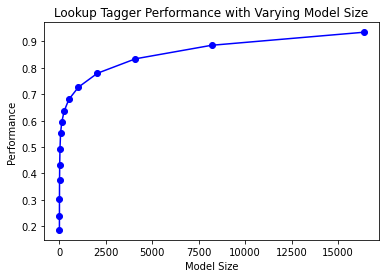

In [24]:
def performance(cfd, wordlist):
    # create a base model for the lookup tagger
    lt = dict((word, cfd[word].max()) for word in wordlist)
    
    # instantiate tagger with backoff tagger
    baseline_tagger = UnigramTagger(model=lt, backoff=DefaultTagger('NN'))
    
    # evaluate tagger
    return baseline_tagger.evaluate(brown.tagged_sents(categories='news'))


def display():
    import pylab
    
    # create a FreqDist & extract 100 most common words
    word_freqs = FreqDist(brown.words(categories='news')).most_common()
    # extract words only
    words_by_freq = [w for (w, _) in word_freqs]
    # create a Conditional Freq Dist
    cfd = ConditionalFreqDist(brown.tagged_words(categories='news'))
    # assign various tagger sizes
    sizes = 2 ** pylab.arange(15)
    # evalute taggers
    perfs = [performance(cfd, words_by_freq[:size]) for size in sizes]
    # generate plot
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()

# invoke function
display()

Observe that performance __initially increases rapidly__ as the model size grows, eventually reaching a __plateau__, when large increases in model size yield little improvement in performance.

<a name="evaluation"></a>
## 5.4.4 Evaluation

In the above examples, you will have noticed an __emphasis on accuracy scores__. In fact, __evaluating the performance of such tools is a central theme in NLP__. 

Recall the processing pipeline in [fig-sds](https://www.nltk.org/book/ch01.html#fig-sds); any errors in the output of one module are greatly multiplied in the downstream modules.

__We evaluate the performance of a tagger relative to the tags a human expert would assign__. Since we don't usually have access to an expert and impartial human judge, we make do instead with __gold standard test data__. 

This is a __corpus which has been manually annotated__ and which is accepted as a standard against which the guesses of an automatic system are assessed. The tagger is regarded as being correct if the tag it guesses for a given word is the same as the gold standard tag.

Of course, the humans who designed and carried out the original gold standard annotation were only human. Further analysis might show mistakes in the gold standard, or may eventually lead to a revised tagset and more elaborate guidelines. Nevertheless, the gold standard is by definition "correct" as far as the evaluation of an automatic tagger is concerned.

__Developing an annotated corpus is a major undertaking__. 

Apart from the data, it generates __sophisticated tools__, __documentation__, and __practices for ensuring high quality annotation__.

The __tagsets__ and other coding schemes inevitably __depend on some theoretical position that is not shared by all__, however corpus creators often go to great lengths to make their work as theory-neutral as possible in order to maximize the usefulness of their work.